- File sources : https://www.kaggle.com/datasets/arashnic/lung-dataset/data

In [1]:
%%time

import warnings
warnings.filterwarnings('ignore')

CPU times: user 36 µs, sys: 14 µs, total: 50 µs
Wall time: 62 µs


In [2]:
%%time

import wave

# Open the audio file
with wave.open('/kaggle/input/lung-dataset/Audio Files/BP101_Asthma,E W,P L M,12,F.wav', 'rb') as wf:
    sample_rate = wf.getframerate()  # Get sample rate calculation
    number_of_frames = wf.getnframes()  # Optional: Get number of frames
    print(f'Sample Rate: {sample_rate}')

Sample Rate: 4000
CPU times: user 1.48 ms, sys: 2.82 ms, total: 4.29 ms
Wall time: 12.1 ms


In [3]:
%%time

import tensorflow as tf
import tensorflow_hub as hub

# Load the YAMNet model from TensorFlow Hub
yamnet_model = hub.load('https://www.kaggle.com/models/google/yamnet/TensorFlow2/yamnet/1')

CPU times: user 7.01 s, sys: 1.35 s, total: 8.36 s
Wall time: 15 s


Processing audio files...
Processed: EP76_N,N,A L U,31,M.wav - Class: Animal - Confidence: 0.111
Processed: EP93_N,N,P R M,75,M.wav - Class: Noise - Confidence: 0.165
Processed: BP13_Heart Failure,C,P L L,55,M.wav - Class: Heart sounds, heartbeat - Confidence: 0.264
Processed: BP23_Lung Fibrosis,Crep,P R L ,50,M.wav - Class: Heart sounds, heartbeat - Confidence: 0.396
Processed: EP67_heart failure,Crep,P R L ,24,F.wav - Class: Heart sounds, heartbeat - Confidence: 0.395
Processed: EP79_asthma,E W,A R U,46,M.wav - Class: Speech - Confidence: 0.289
Processed: BP24_heart failure,Crep,P R L ,76,F.wav - Class: Stomach rumble - Confidence: 0.493
Processed: DP32_N,N,A R L,30,M.wav - Class: Vehicle - Confidence: 0.228
Processed: DP83_N,N,A R U,18,F.wav - Class: Vehicle - Confidence: 0.155
Processed: EP58_asthma,E W,P L M,40,M.wav - Class: Outside, rural or natural - Confidence: 0.136
Processed: BP50_N,N,P R L ,27,M.wav - Class: Sound effect - Confidence: 0.258
Processed: DP36_pneumonia,Crep,P 

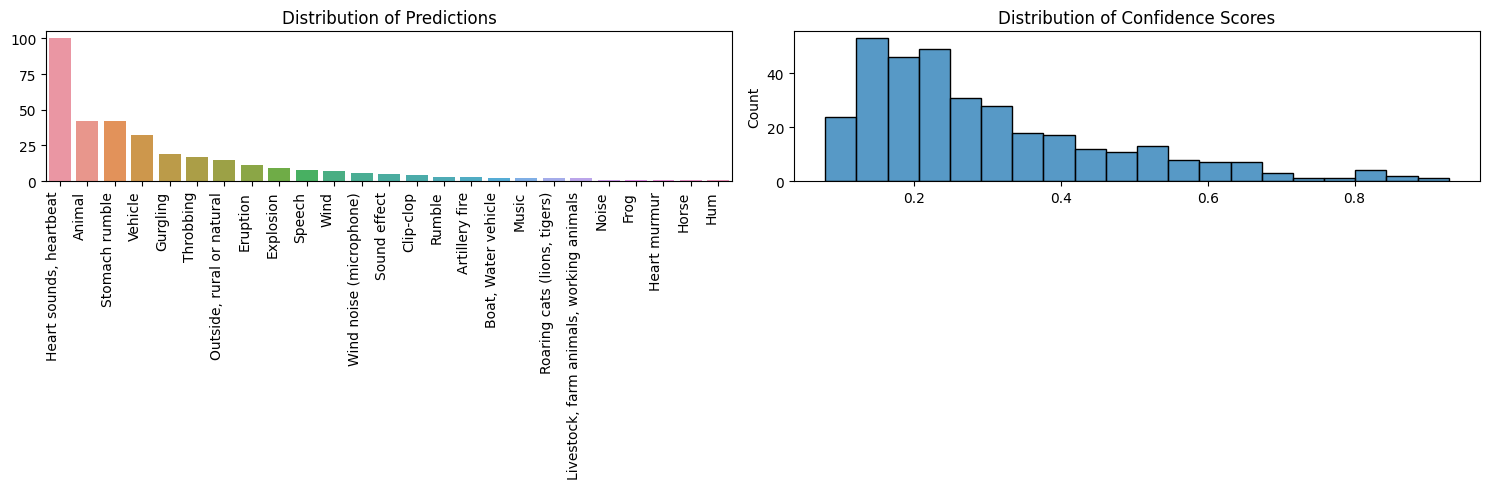

Filtered results saved to lung_disease_sounds.csv
CPU times: user 15.8 s, sys: 1.22 s, total: 17 s
Wall time: 21.4 s


In [4]:
%%time

import os 
import librosa 
import numpy as np 
import soundfile as sf 
import matplotlib.pyplot as plt 
import seaborn as sns 
import pandas as pd 
import tensorflow as tf 
import tensorflow_hub as hub 
import io 
import csv 

# Function to extract class names from the model's class_map_path
def class_names_from_csv(class_map_csv_text):
    """Returns list of class names corresponding to score vector."""
    class_map_csv = io.StringIO(class_map_csv_text)
    # Skip the header
    csv_reader = csv.reader(class_map_csv)
    next(csv_reader)
    class_names = [display_name for (class_index, mid, display_name) in csv_reader]
    return class_names

# Load class names from the model's class_map_path
class_map_path = yamnet_model.class_map_path().numpy()
class_names = class_names_from_csv(tf.io.read_file(class_map_path).numpy().decode('utf-8'))

def preprocess_audio(audio_file_path, target_sr=4000):
    """ Preprocess audio file for YAMNet input.
    
    Parameters:
    -----------
    audio_file_path : str
        Path to audio file
    target_sr : int
        Target sampling rate (YAMNet expects 16kHz)

    Returns:
    --------
    numpy array : Preprocessed audio waveform
    """
    try:
        # Load and resample audio
        waveform, sr = librosa.load(audio_file_path, sr=target_sr)
        # Ensure minimum duration (1 second)
        if len(waveform) < target_sr:
            waveform = np.pad(waveform, (0, target_sr - len(waveform)))
        return waveform
    except Exception as e:
        print(f"Error processing {audio_file_path}: {str(e)}")
        return None

def classify_audio_file(audio_file_path):
    """ Classify audio file using YAMNet.
    
    Parameters:
    -----------
    audio_file_path : str
        Path to audio file

    Returns:
    --------
    tuple : (predicted_class, confidence_score)
    """
    try:
        # Preprocess audio
        waveform = preprocess_audio(audio_file_path, target_sr=4000)  # YAMNet expects kHz
        if waveform is None:
            return None, None
        # Run the model
        scores, embeddings, spectrogram = yamnet_model(waveform)
        # Get the predicted class and confidence
        class_scores = scores.numpy().mean(axis=0)
        predicted_class_idx = np.argmax(class_scores)
        confidence_score = class_scores[predicted_class_idx]
        # Get class name from the loaded class names
        predicted_class = class_names[predicted_class_idx]
        return predicted_class, confidence_score
    except Exception as e:
        print(f"Error classifying {audio_file_path}: {str(e)}")
        return None, None

def process_audio_directory(audio_directory, limit=500):
    """ Process all audio files in a directory.
    
    Parameters:
    -----------
    audio_directory : str
        Path to directory containing audio files
    limit : int
        Maximum number of files to process

    Returns:
    --------
    list : List of (filename, prediction, confidence) tuples
    """
    results = []
    # Get list of audio files, now .wav format
    audio_files = [f for f in os.listdir(audio_directory) if f.lower().endswith('.wav')][:limit]
    # Process each file
    for audio_file in audio_files:
        audio_file_path = os.path.join(audio_directory, audio_file)
        predicted_class, confidence = classify_audio_file(audio_file_path)
        if predicted_class is not None:
            results.append((audio_file, predicted_class, confidence))
        print(f"Processed: {audio_file} - Class: {predicted_class} - Confidence: {confidence:.3f}")
    return results

def plot_results(results):
    """ Plot classification results.
    
    Parameters:
    -----------
    results : list
        List of (filename, prediction, confidence) tuples
    """
    if not results:
        print("No results to plot.")
        return
    
    # Extract predictions and confidences
    predictions = [r[1] for r in results]
    confidences = [r[2] for r in results]

    # Plot distribution of predictions
    plt.figure(figsize=(15, 5))
    
    # Prediction distribution
    plt.subplot(1, 2, 1)
    pred_counts = pd.Series(predictions).value_counts()
    sns.barplot(x=pred_counts.index, y=pred_counts.values)
    plt.xticks(rotation=90, ha='right')
    plt.title('Distribution of Predictions')
    
    # Confidence distribution
    plt.subplot(1, 2, 2)
    sns.histplot(confidences, bins=20)
    plt.title('Distribution of Confidence Scores')

    plt.tight_layout()
    plt.show()

# Main execution
if __name__ == "__main__":
    # Directory containing the audio files
    audio_directory = '/kaggle/input/lung-dataset/Audio Files'
    # Process audio files
    print("Processing audio files...")
    results = process_audio_directory(audio_directory, limit=500)

    # Create DataFrame
    if results:
        df_results = pd.DataFrame(results, columns=['filename', 'prediction', 'confidence'])
        # Print summary statistics
        print("\nSummary Statistics:")
        print("-" * 50)
        print(f"Total files processed: {len(df_results)}")
        print("\nPrediction counts:")
        print(df_results['prediction'].value_counts().head())
        print("\nConfidence score statistics:")
        print(df_results['confidence'].describe())
        # Plot results
        plot_results(results)
        
        # Save results confidence score is 0.1 or higher
        df_filtered = df_results[df_results['confidence'] >= 0.1]
        # Save the filtered DataFrame to a CSV file
        output_csv_path = 'lung_disease_sounds.csv'
        df_filtered.to_csv(output_csv_path, index=False)
        print(f"Filtered results saved to {output_csv_path}")
    else:
        print("No audio files processed successfully.")